In [5]:
from IPython.display import Image
from lib.utils import *

# Generative Adversarial Networks - 50 points

Please review Lectures 10-11 for the notation and the setup in this exercise.

As a basic example for the implementation of GANs, we will try to learn the density of a 2D mixture of Gaussian (MoG) distribution from empirical samples using the Wasserstein GAN (WGAN) framework. MoG distributions are multi-modal, and allow to us visualize multiple "modes" of the distribution. 

Both your generator neural network $h_\mathbf{x}$ and dual variable neural network $\mathtt{d}_\mathbf{y}$ are defined as two hidden layer networks:

\begin{equation}
    \mathcal{H}:=\{h: h_{\mathbf{x}}(\omega)=X_3\texttt{relu}(X_2\texttt{relu}(X_1 \omega + x_1)+ x_2) + x_3\},
    \qquad \mathcal{D}:= \{\mathtt{d}: \mathtt{d}_{\mathbf{x}}({\bf a})=
    Y_3\texttt{relu}(Y_2\texttt{relu}(Y_1 {\bf a} + y_1)+ y_2)+y_3\},
\end{equation}

where $\mathbf{x} =[x_1;x_2;{X_1};{X_2}; X_3]$ are the "generator" parameters, and $\mathbf{y} =[y_1;y_2;{Y_1};{Y_2}; Y_3] $ are the
"dual" or the "discriminator" parameters. The dimensions of these parameters will be apparent from the context as well as the base code provided along with the homework. 

In the following cells, you will implement the two neural networks as well as the spectral normalization ([Myato 2018](https://arxiv.org/abs/1802.05957)) method that enforces a Lipschitz constraint.

**(1)** (3 points) Implement a two hidden layer MLP with ReLU below for the generator. See `torch.nn.Sequential` docs for a start.

In [6]:
class Generator(nn.Module):

    def __init__(self, noise_dim=2, output_dim=2, hidden_dim=100):
        super().__init__()
        
        # Using Sequential to create a small model, stack the given layer one after the other
        self.inner = nn.Sequential(nn.Linear(noise_dim, hidden_dim),
                                   nn.ReLU(),
                                   nn.Linear(hidden_dim, hidden_dim),
                                   nn.ReLU(),
                                   nn.Linear(hidden_dim, output_dim)
                                  )

    def forward(self, z):
        return self.inner(z)

**(2)** (20 points) Implement a two hidden layer MLP with ReLU below for the Discriminator and implement the spectral normalization method.

**Remark:** The `spectral_normalization` does not need to return a value. It should modify the parameters $\mathbf{y}$ of the dual network $\mathtt{d}_{\mathbf{y}}$ in place. Remember not to track gradients in those operations.

In [7]:
from torch import linalg as LA

class DualVariable(nn.Module):

    def __init__(self, input_dim=2, hidden_dim=100, c=1e-2):
        super().__init__()
        self.c = c
        
        # Using Sequential to create a small model, stack the given layer one after the other
        self.inner = nn.Sequential(
          nn.Linear(input_dim, hidden_dim),
          nn.ReLU(),
          nn.Linear(hidden_dim, hidden_dim),
          nn.ReLU(),
          nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        return self.inner(x)

    def enforce_lipschitz(self):
        self.spectral_normalisation()

    def spectral_normalisation(self):
        """
        Perform spectral normalisation, forcing the singular value of the weights to be upper bounded by 1.
        """
        with torch.no_grad():
            for name, param in self.named_parameters():
                
                if not "weight" in name:
                    continue
                    
                #for param in self.named_parameters():    
                # modify the parameters by dividing with the spectral norm (the 2-norm)
                # torch.linalg.matrix_norm() computes a matrix norm.
                norm = LA.matrix_norm(param, ord=2)
                if norm > 1:
                    param = param / norm
                    
                
                

**(3)** (2 points) Spectral Normalization applied to a matrix outputs a matrix whose largest singular value is upper bounded by one. Is Spectral Normalization a projection (in the $\ell_2$ sense) ? Think of a diagonal square matrix and try figure out what spectral normalization does and compare that to what a projection onto the set of matrices with largest singular value less than 1 would do.

The spectral norm of a matrix A is the largest singular value of A (i.e., the square root of the largest eigenvalue of the matrix $A^\star A$). It corresponds to the greatest distortion of the unit circle or sphere. Spectral normalisation divides each element by the spectral norm. 

Let $A = \begin{bmatrix} 4 & 0 \\ 0 & 1 \end{bmatrix}$

The largest eigenvalue of A is 4. Therefore

$A_{spectral-normalised} = \begin{bmatrix} 1 & 0 \\ 0 & 1/4 \end{bmatrix}$

Now, the new matrix is a matrix whose largest singular value is upper bounded by one.

Spectral normalisation is not a projection in the $\ell_2$ sense.

$A_{spectral-normalised}^2 = \begin{bmatrix} 1 & 0 \\ 0 & 1/16 \end{bmatrix} \neq A_{spectral-normalised} = \begin{bmatrix} 1 & 0 \\ 0 & 1/4 \end{bmatrix}$

Idempotence property of projection does not hold, therefore spectral normalisation is not a projection in the $\ell_2$ sense.

**(3)** (1 point) Implement a stochastic estimate of the objective function of the minimax game (in the cell below):

$$
\min_{\mathbf{x} \in \mathcal{X}} \max_{\mathbf{y} \in \mathcal{Y}} 
\mathbb{E}[\mathtt{d}_{\mathbf{y}}({\bf a})] - \mathbb{E}[\mathtt{d}_{\mathbf{y}}(h_{\mathbf{x}}(\omega))] = 
\min_{h \in \mathcal{H}} \max_{\mathtt{d} \in \mathcal{F}}
\mathbb{E}[\mathtt{d}({\bf a})] - \mathbb{E}[\mathtt{d}(h(\omega))],
$$

In [8]:
def objective(d, g, data_sample, noise_sample):
    # h = g
    #E_d_a = torch.mean(d(data_sample))
    #E_d_h_w = torch.mean(d(g(noise_sample)))
    E_d_a = (d(data_sample)).mean()
    E_d_h_w = (d(g(noise_sample))).mean()
    W1 = E_d_a - E_d_h_w
    return W1

**(4)** (20 points) Implement an alternating gradient ascent/descent update, training the generator 1 time for every 5 dual updates. More specifically, you will implement the conceptual algorithm below using the parameters of the neural networks

$$
\begin{aligned}
\mathtt{d}^{k+1} &= \text{EnforceLipschitz} (\mathtt{d}^k + \gamma \text{SG}_\mathtt{d}(\mathtt{d}^k, h^kk)), && \text{(if $k$ mod $5 \neq 0$) }\\
h^{k+1} &= h^{k} - \gamma \text{SG}_h(\mathtt{d}^{k+1}, h^k) && \text{(if $k$ mod $5 =0$)},
\end{aligned}
$$

where $\text{SG}$ is the stochastic gradient oracle. To perform the optimization, you have two `Pytorch` optimizers `d_optim` and `g_optim`, which have a `.step()` method that updates the discriminator and generator parameters respectively.

Use the objective function you have just written. The iteration count is held by the `step_k` argument. The agument `d_ratio` defines how many more times we train the discriminator that train the generator. 

For later, to display the progress, write the function so that it returns the value of the objective function.

**Hints**: Don't forget that the generator seeks to minimize and the discriminator seeks to maximize. Pytorch optimizers step in the _negative_ gradient direction, keep that in mind.

In [9]:
def alternating_update(step_k, d, g, d_optim, g_optim, noise_samples, real_samples, d_ratio=5):
    d_optim.zero_grad()
    g_optim.zero_grad()
    
    l = objective(d, g, real_samples, noise_samples)
    
    if step_k % d_ratio==0:
        d.eval()
        g.train()
        min_loss = l # generator seeks to minimize
        min_loss.backward()
        with torch.no_grad():
            g_optim.step()
            #g_optim.zero_grad()
    else:
        d.train()
        g.eval()
        max_loss = l #-l discriminator seeks to maximize
        max_loss.backward()
        with torch.no_grad():
            d_optim.step()
            d.enforce_lipschitz()
            #d_optim.zero_grad()
            
    # recalculate loss
    l = objective(d, g, real_samples, noise_samples)

    return l

With all the ingredients in hand, we can train our GAN.

The following cell defines the two networks.

In [10]:
hidden_dim = 100 #increase this
d = DualVariable(input_dim=2, hidden_dim=hidden_dim, c=1.0)
g = Generator(noise_dim=2, output_dim=2, hidden_dim=hidden_dim)

**(5)** (2 points) Define an optimizer for each of the networks. We recommend choosing `Adam` with betas $(0.0, 0.9)$.

In [11]:
step_size = 0.01 #decrease this
d_optim = torch.optim.Adam(d.parameters(), lr = step_size, betas = (0.0, 0.9), maximize = True)
g_optim = torch.optim.Adam(g.parameters(), lr = step_size, betas = (0.0, 0.9))

The following cell runs the training loop for 2000 iterations, this might take a few minutes.

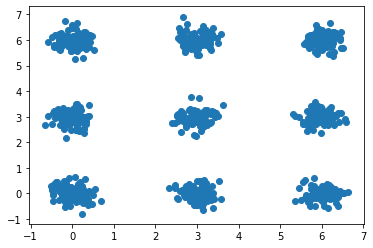

W1:-4.3e+01 GTrue: 100%|██████████| 2000/2000 [08:36<00:00,  3.87it/s] 


<Figure size 432x288 with 0 Axes>

In [12]:
train(d, g, d_optim, g_optim, alternating_update, n_iter=2000) # and increase this

Once the training is complete, you can visualize the training process in the following gif. (If you encounter problems seeing the gif, open it in a separate tab, it can be found in the same directory as this notebook).

In [ ]:
Image("movie.gif")

#Note - I had to delete the output of this cell, otherwise, it is too large to upload to Moodle.

**(6)** (2 points) Briefly comment on what you observe. Play with the network sizes, the step sizes, the number of iterations, all while keeping in mind the difficulties of min-max optimization you've analyzed in the previous notebook.

In the notebook 1, we saw that solving min-max problems could be extremely challenging. They come with difficulties such as scalability, mode collapse, periodic cycling. In this notebook, it is observed that when the step size (learning rate) is larger, the model is diverged and unable to be trained successfully since it gets stuck. Therefore, a small enough step size is required for the training algorithm to converge. Moreover, a large enough network size is needed. When the learning rate is large and the number of hidden dimensions isn't large enough, the algorithm doesn't converge, no matter the number of iterations. And it required a much larger number of iterations to acquire good results. When I ran it with 0.001 step size, 400 hidden layers and 10 000 iterations, very satisfactory results were reached. These results are presented in a compressed gif.